In [1]:
a = 5 
a

5

In [ ]:
# tf.keras.backend.clear_session()

In [ ]:
# ML CODE TO test noiseless lightcurves
# with different limb darkening coefficients
# No. of datapoints for lightcurve = 120
# Predictions (a) without sampling the test light curve and
# (b) with sampling is given here

In [2]:
# Import TF and check for GPU

import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))
print("TensorFlow version:", tf.__version__)

# Import required libraries

import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras
from keras import layers
from tensorflow.keras.models import save_model, load_model
import math
import sys
from numpy import array,append,arange,zeros,exp,sin,random,std
from scipy.interpolate import interp1d

2024-03-20 14:43:48.878018: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-20 14:43:49.814115: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/abraham/miniconda3/envs/tf/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.25.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
TensorFlow version: 2.12.1


In [3]:
# 1. Load Test Dataset
## Load Test Set
test_shape_dir = '/scratch/abraham/Documents/mega_git/mega/data/test/npy/shape/test_shape_1_9times.npy'
test_lc_dir = '/scratch/abraham/Documents/mega_git/mega/data/test/npy/lc/test_lc_1_to_9.npy'

# loading lc with different LDCs not in training set
# test_shape_dir = '/scratch/abraham/Documents/mega_git/mega/data/test/npy/shape/shape_1.npy'
# test_lc_dir = '/scratch/abraham/Documents/mega_git/mega/data/test/npy/lc/lc_17_shape_1.npy'

test_lc = np.load(test_lc_dir)
test_shape = np.load(test_shape_dir)
# Check equality of number of dataset
print('test_lc.shape =',test_lc.shape)
print('test_shape.shape = ',test_shape.shape)
if len(test_lc)==len(test_shape):
    print("test Set: No. of LC = No. of shapes")
else:
    sys.exit("EXIT: test Set: No. of LC != No. of shapes")


test_lc.shape = (2250, 100)
test_shape.shape =  (2250, 38, 38)
test Set: No. of LC = No. of shapes


Extended the light curves


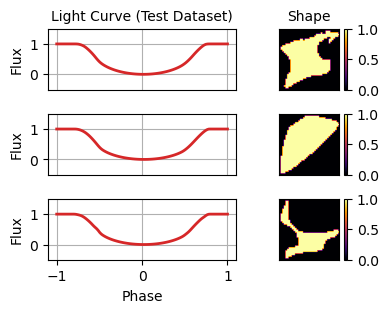

In [4]:
# Normalize the image, convert to opacity map
## Test Set
test_shape = test_shape/np.amax(test_shape)
test_shape_where_0 = np.where(test_shape == 0)
test_shape_where_1 = np.where(test_shape == 1)
test_shape[test_shape_where_0] = 1  # 1 represent the shape (1 opacity)
test_shape[test_shape_where_1] = 0  # 0 represent background (0 opacity)


# Normalize the lightcurves
## - Test Set
test_lc_scaled = np.zeros(test_lc.shape)
for i in np.arange(len(test_lc_scaled)):
    test_lc_scaled[i] = (test_lc[i] - np.amin(test_lc[i]))/(np.amax(test_lc[i]) - np.amin(test_lc[i]))

# Append with ones
## - Test Set
test_lc_scaled_append = np.ones((test_lc.shape[0],120))
for i in np.arange(len(test_lc_scaled)):
    test_lc_scaled_append[i,10:110] = test_lc_scaled[i]
print("Extended the light curves")

# Verification
# Plot - Test LCs
num = 3
fig,ax=plt.subplots(num,2, figsize=(4,3), gridspec_kw={ 'width_ratios': [2,1],
        'wspace': 0.2,'hspace': 0.4})
plt.rcParams['figure.dpi'] = 400

ax[0][1].set_title('Shape',size=10)
ax[0][0].set_title('Light Curve (Test Dataset)',size=10)
ax[num-1][0].set_xlabel('Phase',size=10)
ph = np.linspace(-1,1,len(test_lc_scaled_append[0]))
# advance = 60

i = 0
for i in np.arange(0,num):
    k = random.randint(0, len(test_lc_scaled_append)-1)
    ax[i][1].tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
    if(i<num-1): ax[i][0].tick_params(labelbottom = False, bottom = False)
    img = ax[i][1].imshow(test_shape[k],cmap='inferno')
    plt.colorbar(img)
    ax[i][0].set_ylabel('Flux',size=10)
    ax[i][0].set_ylim(-0.5,1.5)
    ax[i][0].plot(ph,test_lc_scaled_append[k],color = 'tab:red',linewidth='2')
    ax[i][0].grid('on')
    i = i + 1


In [5]:
model_load = load_model("/scratch/abraham/Documents/mega_git/mega/ml_model/nov13_model1/nov13_model1_sample_interpolate_no_noise_unf_samplept_20to60.h5")
results = model_load.evaluate(test_lc_scaled_append, test_shape, batch_size=128)
results

2024-03-20 14:44:04.744161: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 29294 MB memory:  -> device: 0, name: Tesla V100-PCIE-32GB, pci bus id: 0000:3b:00.0, compute capability: 7.0
2024-03-20 14:44:06.497312: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600


18/18 [==============================] - 2s 16ms/step - loss: 0.1040


0.10402382910251617

In [7]:
# Test on the ML model - Test Dataset - Original Simulated light curve 
# (i.e. without sampling and interpolation)
# Test dataset - Prediciton
test_predict_shape = model_load.predict(test_lc_scaled_append)
test_predict_shape_normalized = np.zeros(test_predict_shape.shape)
for i in np.arange(len(test_predict_shape)):
    test_predict_shape_normalized[i] = (test_predict_shape[i] - np.amin(test_predict_shape[i]))/(np.amax(test_predict_shape[i]) - np.amin(test_predict_shape[i]))
print("Normalized the predicted shape")
test_predict_shape = test_predict_shape_normalized
del test_predict_shape_normalized

71/71 [==============================] - 1s 7ms/step
Normalized the predicted shape


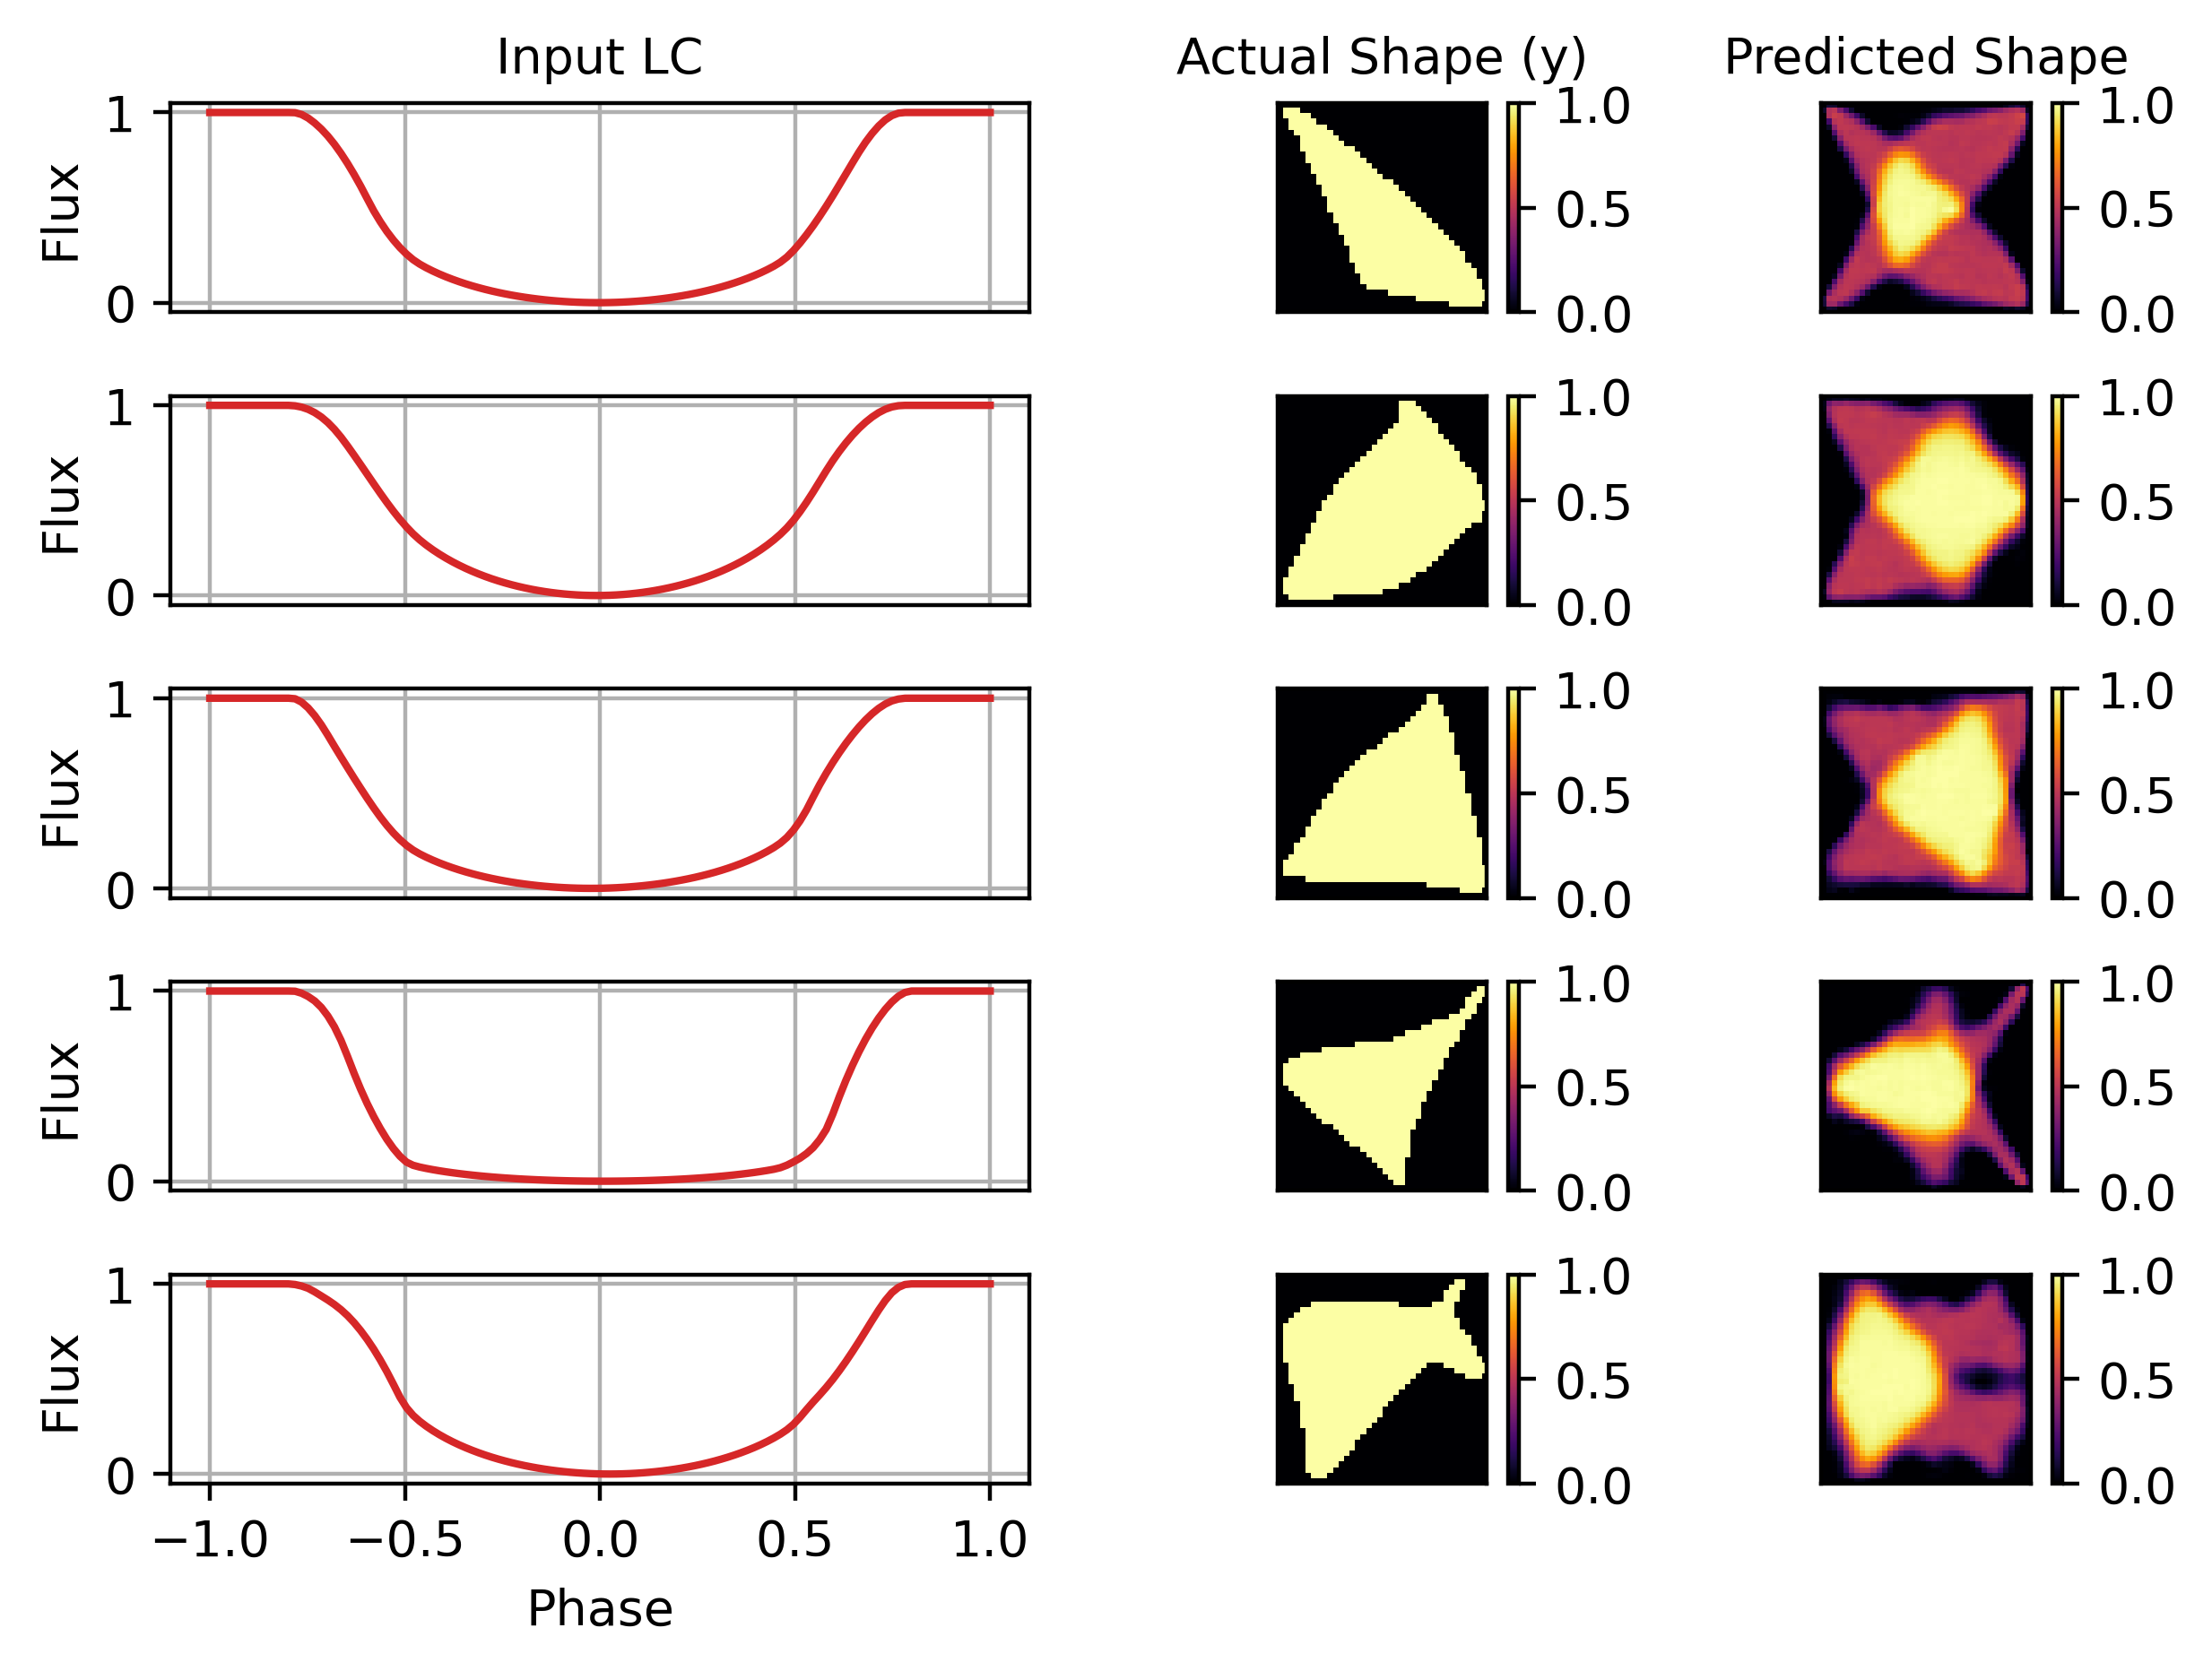

In [8]:
# Plots of prediction without sampling the test light curve
num = 5
fig,ax=plt.subplots(num,3, figsize=(7,5), gridspec_kw={ 'width_ratios': [2,1,1],
        'wspace': 0.2,'hspace': 0.4})
plt.rcParams['figure.dpi'] = 400

ax[0][0].set_title('Input LC',size=10)
ax[0][1].set_title('Actual Shape (y)',size=10)
ax[0][2].set_title(r'Predicted Shape',size=10)
ax[num-1][0].set_xlabel('Phase',size=10)
ph = np.linspace(-1.0,1.0,len(test_lc_scaled_append[0]))
# advance = 60
for i in range(num):
    k =  random.randint(0, len(test_lc_scaled_append)-1) # 249 - i #
    ax[i][2].tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
    ax[i][1].tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
    if(i<num-1): ax[i][0].tick_params(labelbottom = False, bottom = False)
    img = ax[i][1].imshow(test_shape[k],cmap='inferno')
    plt.colorbar(img)
    ax[i][0].set_ylabel('Flux',size=10)
    # ax[i][0].set_ylim(-0.5,1.5)
    ax[i][0].plot(ph, test_lc_scaled_append[k],color = 'tab:red',linewidth=1.5)
    ax[i][0].grid('on')
    img = ax[i][2].imshow(test_predict_shape[k],cmap='inferno')
    plt.colorbar(img)

# plt.suptitle('Test Dataset Prediction (LDCs a = 0.23, b = 0.05)')
plt.show()

In [16]:
# All the required codes for folding and calculating MSE

def fold_original_image_array(org_image_array):
    # Return an array containing folding each 2d shape
    folded_org_image_array = np.zeros((int(org_image_array.shape[0]),int(org_image_array.shape[1]/2),int(org_image_array.shape[2]) ))
    for i in np.arange(len(org_image_array)):
        image_top = org_image_array[i,0:int(org_image_array.shape[1]/2),:]
        image_bottom = org_image_array[i,int(org_image_array.shape[1]/2):,:]
        image_bottom_flip = np.flipud(image_bottom)
        folded_org_image_array[i] = image_bottom_flip+image_top
    folded_org_image_array[folded_org_image_array>0] = 1
    return(folded_org_image_array)

def fold_predicted_image_array(org_image_array):
    threshold = 0.3
    # Return an array containing folding each 2d shape
    folded_org_image_array = np.zeros((int(org_image_array.shape[0]),int(org_image_array.shape[1]/2),int(org_image_array.shape[2]) ))
    for i in np.arange(len(org_image_array)):
        image_top = org_image_array[i,0:int(org_image_array.shape[1]/2),:]
        image_bottom = org_image_array[i,int(org_image_array.shape[1]/2):,:]
        image_bottom_flip = np.flipud(image_bottom)
        folded_org_image_array[i] = image_bottom_flip+image_top
        folded_org_image_array[i] = (folded_org_image_array[i] - np.amin(folded_org_image_array[i]))/(np.amax(folded_org_image_array[i]) - np.amin(folded_org_image_array[i]))
    folded_org_image_array[folded_org_image_array>=threshold] = 1
    folded_org_image_array[folded_org_image_array<threshold] = 0
    return(folded_org_image_array)

def calc_MSE(ary1,ary2):
    MSE = 0
    if ary1.shape == ary2.shape:
        for i in np.arange(len(ary1)):
            MSE = MSE + np.mean((ary1[i] - ary2[i])**2)
        MSE = MSE/len(ary1)
        print("MSE = ",MSE)
        return(MSE)
    else:
        print("Given array shape not same")

def fold_and_calc_MSE(test_shape,test_predict_shape):
    # Fold the original shapes
    folded_test_shape_array = fold_original_image_array(test_shape)

    # Fold the predicted shapes for different SNR
    folded_test_predict_shape_array = fold_predicted_image_array(test_predict_shape)
    mse_folded = calc_MSE(folded_test_shape_array,folded_test_predict_shape_array)
    print("mse_folded -> ",mse_folded)
# Uncomment and run this code o calculate Folded MSE
# # Fold the original shapes
# folded_test_shape_array = fold_original_image_array(test_shape)

# # Fold the predicted shapes for different SNR
# folded_test_predict_shape_array = fold_predicted_image_array(test_predict_shape)

# print("MSE before folding the shape")
# mse_not_folded = calc_MSE(test_shape,test_predict_shape)
# print("mse_not_folded -> ",mse_not_folded)


# print("MSE after folding the shape")
# mse_folded = calc_MSE(folded_test_shape_array,folded_test_predict_shape_array)
# print("mse_folded -> ",mse_folded)


In [8]:
# Code to sample and interpolate the test light curves
def sample_interpolate_simul_lc(simulated_lc,sample_Ndatapoints_array):
    simulated_lc_interpol = np.zeros((len(simulated_lc),len(simulated_lc[0])))
    print('simulated_lc_interpol.shape = ',simulated_lc_interpol.shape)


    for iteration in np.arange(len(simulated_lc_interpol)):
        ## 1. Select x number of datapoints
        # Original data with 120 elements
        original_x = np.linspace(-1, 1, num=len(simulated_lc[iteration]))
        original_y = simulated_lc[iteration]  

        # Create a quadratic interpolation function
        f = interp1d(original_x, original_y, kind='quadratic')

        # Define the range of x-values for the interpolation with 'train_sample_Ndatapoints elements
        x_interpolation = np.linspace(-1, 1, num=sample_Ndatapoints_array[iteration])

        # Perform the interpolation
        y_interpolated = f(x_interpolation)
        
        ## 2. Interpolate back to 120
        original_x = np.linspace(-1, 1, num=len(y_interpolated))
        original_y = y_interpolated  

        # Create a quadratic interpolation function
        f = interp1d(original_x, original_y, kind='quadratic')

        # Define the range of x-values for the interpolation with 120 elements
        x_interpolation = np.linspace(-1, 1, num=len(simulated_lc[0]))

        # Perform the interpolation
        y_interpolated = f(x_interpolation)


        simulated_lc_interpol[iteration] = y_interpolated
    return(simulated_lc_interpol)


In [9]:
# (A) Uncomment the following code to run the sampling and interpolation for:
# 1. random set of integer datapoints
# 2. single integer datapoints 
# # Array of number of datapoints to sample
# rng = np.random.default_rng()
# # test_sample_Ndatapoints = rng.integers(20,60,len(test_lc_scaled_append))
# test_sample_Ndatapoints = np.uint8(np.ones(len(test_lc_scaled_append))* 50)
# print('test_sample_Ndatapoints[0:10] = ',test_sample_Ndatapoints[0:10])

# (B)
# test_lc_scaled_interpol = sample_interpolate_simul_lc(simulated_lc=test_lc_scaled_append,sample_Ndatapoints_array=test_sample_Ndatapoints)
# results = model_load.evaluate(test_lc_scaled_interpol, test_shape, batch_size=128)
# print(results)

# # (C) Test on the ML model - Test Dataset - Interpolated LC
# # Test dataset - Prediciton
# test_predict_shape = model_load.predict(test_lc_scaled_interpol)
# test_predict_shape_normalized = np.zeros(test_predict_shape.shape)
# for i in np.arange(len(test_predict_shape)):
#     test_predict_shape_normalized[i] = (test_predict_shape[i] - np.amin(test_predict_shape[i]))/(np.amax(test_predict_shape[i]) - np.amin(test_predict_shape[i]))
# print("Normalized the predicted shape")
# test_predict_shape = test_predict_shape_normalized
# del test_predict_shape_normalized

# (D) Plot the results
# num = 5
# fig,ax=plt.subplots(num,3, figsize=(7,5), gridspec_kw={ 'width_ratios': [2,1,1],
#         'wspace': 0.2,'hspace': 0.4})
# plt.rcParams['figure.dpi'] = 400

# ax[0][0].set_title('Input LC',size=10)
# ax[0][1].set_title('Actual Shape (y)',size=10)
# ax[0][2].set_title(r'Predicted Shape',size=10)
# ax[num-1][0].set_xlabel('Phase',size=10)
# ph = np.linspace(-1.0,1.0,len(test_lc_scaled_interpol[0]))
# # advance = 60
# for i in range(num):
#     k =  random.randint(0, len(test_lc_scaled_interpol)-1) # 249 - i #
#     ax[i][2].tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
#     ax[i][1].tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
#     if(i<num-1): ax[i][0].tick_params(labelbottom = False, bottom = False)
#     img = ax[i][1].imshow(test_shape[k],cmap='inferno')
#     plt.colorbar(img)
#     ax[i][0].set_ylabel('Flux',size=10)
#     # ax[i][0].set_ylim(-0.5,1.5)
#     ax[i][0].plot(ph, test_lc_scaled_interpol[k],color = 'tab:red',linewidth=1.5)
#     ax[i][0].grid('on')
#     img = ax[i][2].imshow(test_predict_shape[k],cmap='inferno')
#     plt.colorbar(img)

# plt.suptitle('Test Dataset Prediction\nFirst sampled to 40 points then interpolated back to 120 pts',size=10)
# plt.show()

18/18 [==============================] - 0s 6ms/step - loss: 0.1051


0.10510468482971191

In [10]:
# # Test on the ML model - Test Dataset - Interpolated LC
# # Test dataset - Prediciton
# test_predict_shape = model_load.predict(test_lc_scaled_interpol)
# test_predict_shape_normalized = np.zeros(test_predict_shape.shape)
# for i in np.arange(len(test_predict_shape)):
#     test_predict_shape_normalized[i] = (test_predict_shape[i] - np.amin(test_predict_shape[i]))/(np.amax(test_predict_shape[i]) - np.amin(test_predict_shape[i]))
# print("Normalized the predicted shape")
# test_predict_shape = test_predict_shape_normalized
# del test_predict_shape_normalized

71/71 [==============================] - 1s 7ms/step
Normalized the predicted shape


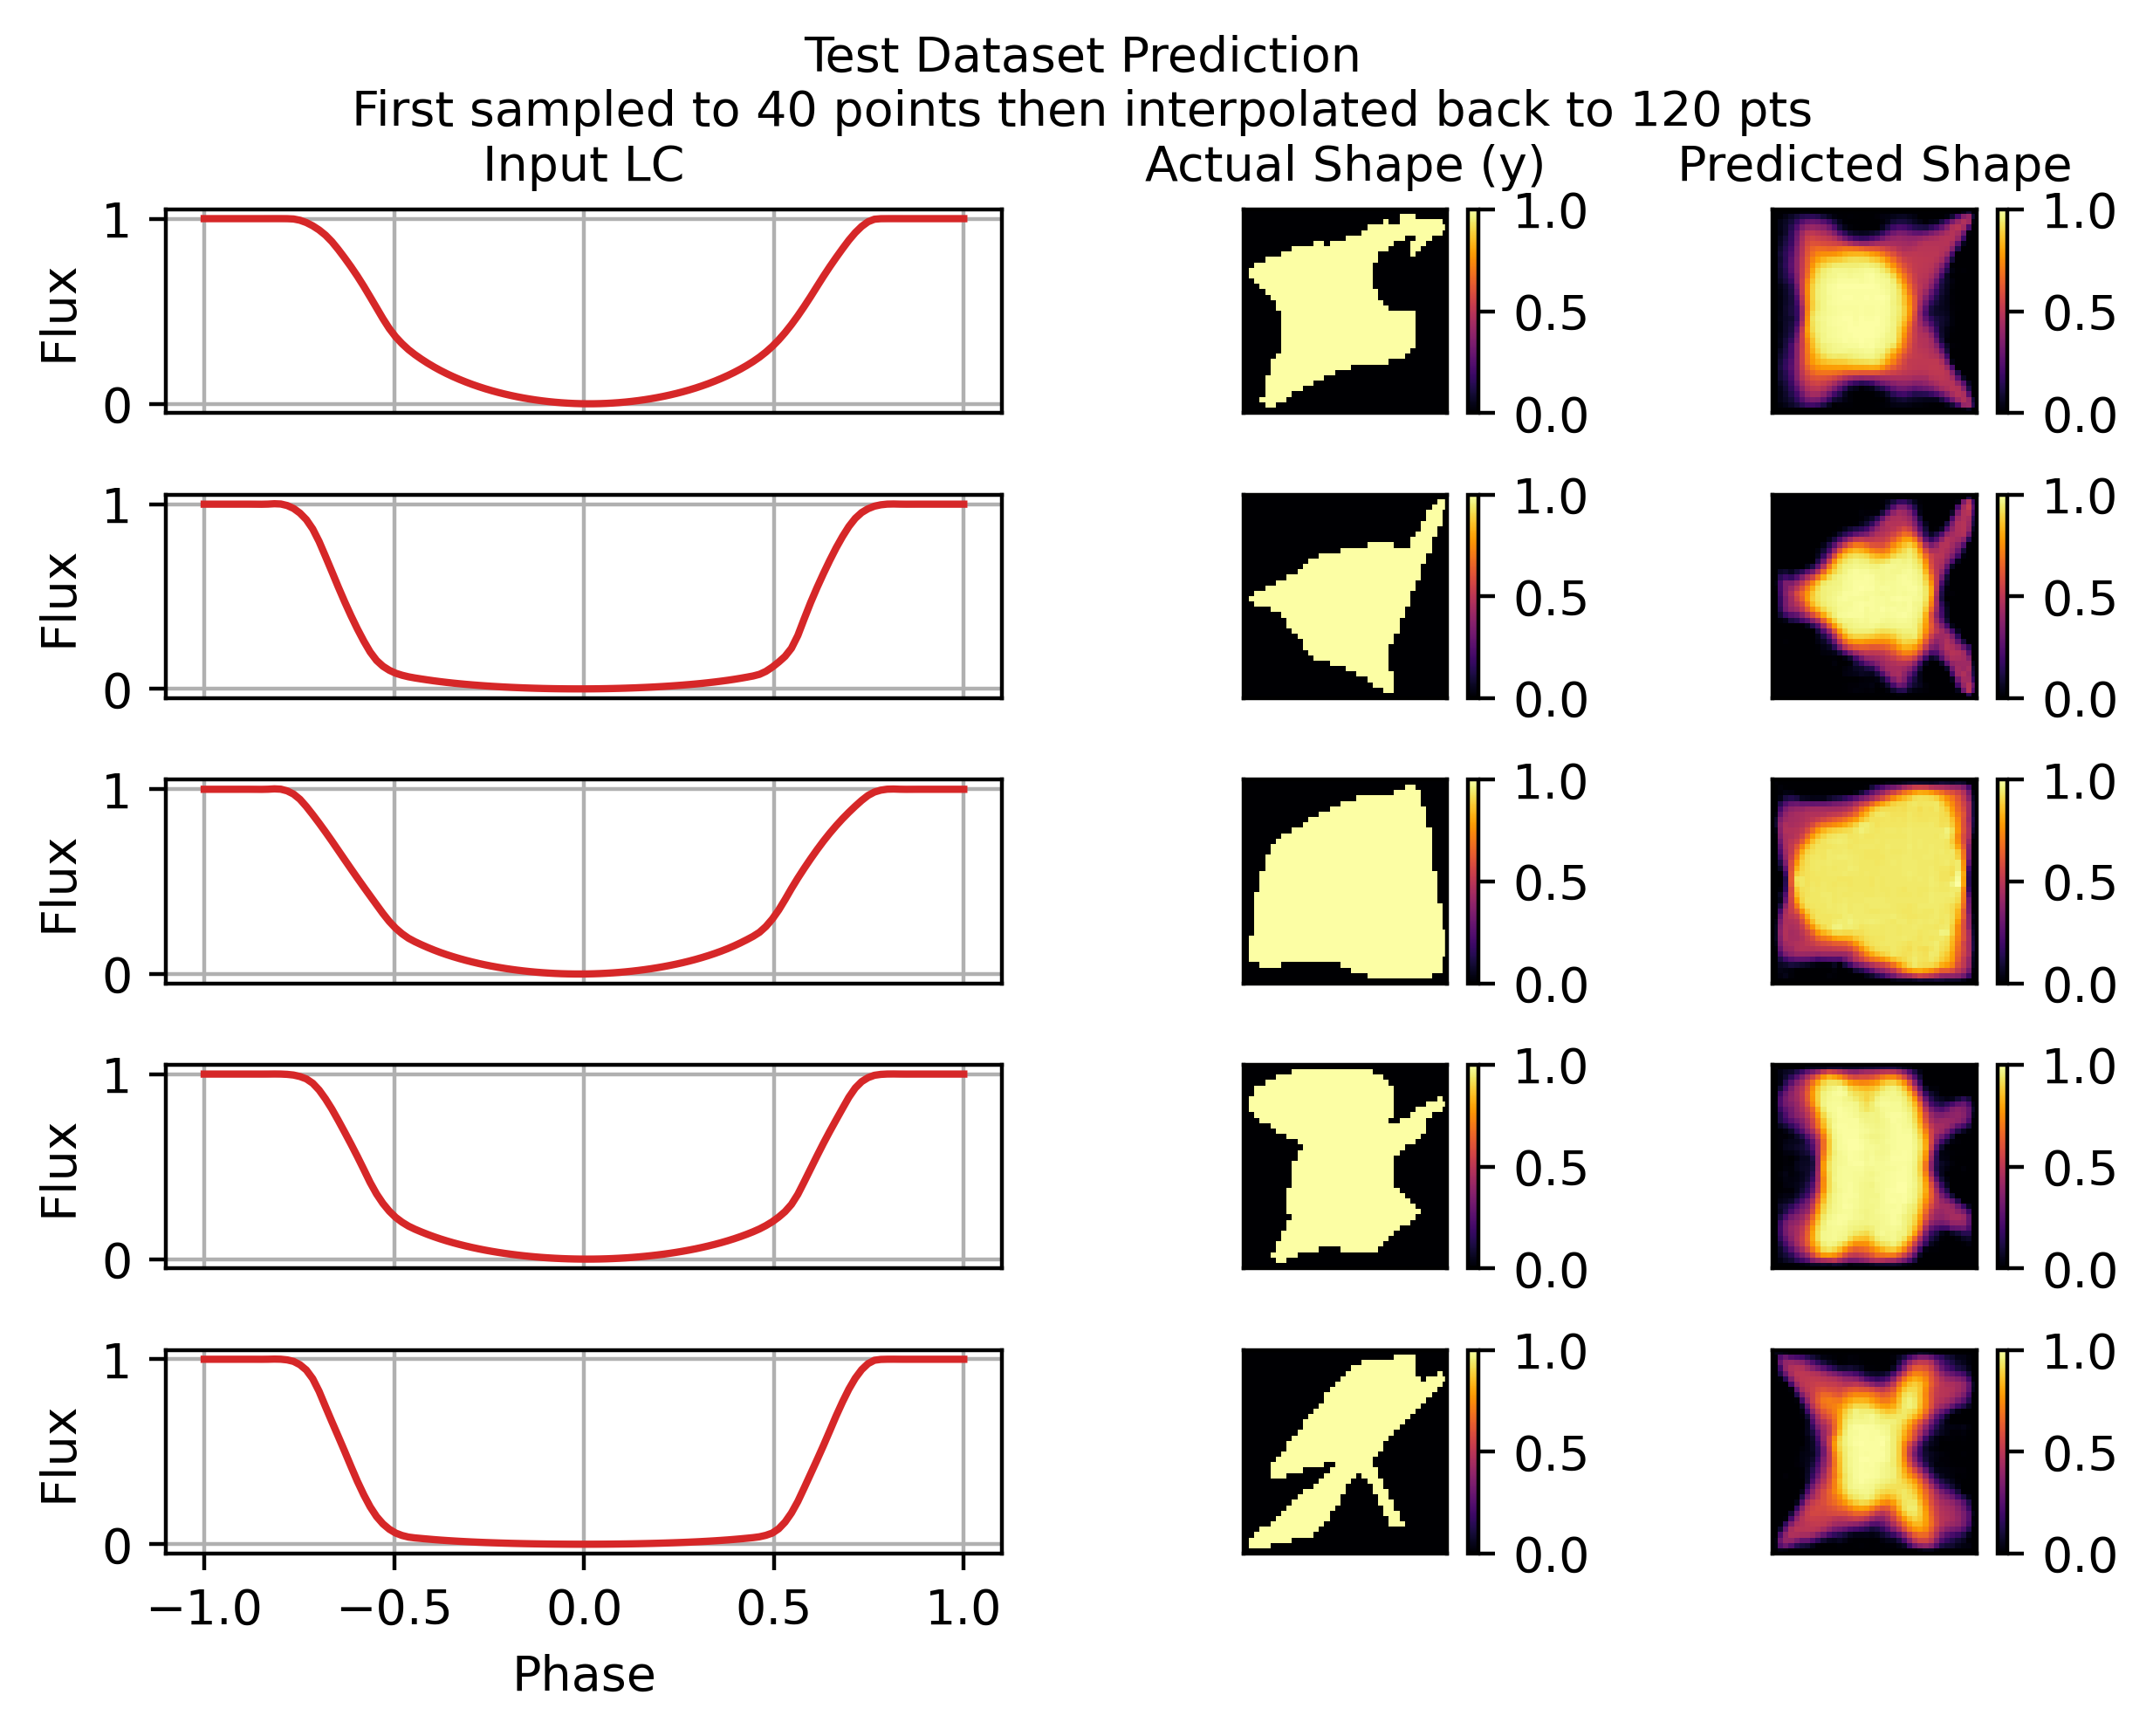

In [11]:

# num = 5
# fig,ax=plt.subplots(num,3, figsize=(7,5), gridspec_kw={ 'width_ratios': [2,1,1],
#         'wspace': 0.2,'hspace': 0.4})
# plt.rcParams['figure.dpi'] = 400

# ax[0][0].set_title('Input LC',size=10)
# ax[0][1].set_title('Actual Shape (y)',size=10)
# ax[0][2].set_title(r'Predicted Shape',size=10)
# ax[num-1][0].set_xlabel('Phase',size=10)
# ph = np.linspace(-1.0,1.0,len(test_lc_scaled_interpol[0]))
# # advance = 60
# for i in range(num):
#     k =  random.randint(0, len(test_lc_scaled_interpol)-1) # 249 - i #
#     ax[i][2].tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
#     ax[i][1].tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
#     if(i<num-1): ax[i][0].tick_params(labelbottom = False, bottom = False)
#     img = ax[i][1].imshow(test_shape[k],cmap='inferno')
#     plt.colorbar(img)
#     ax[i][0].set_ylabel('Flux',size=10)
#     # ax[i][0].set_ylim(-0.5,1.5)
#     ax[i][0].plot(ph, test_lc_scaled_interpol[k],color = 'tab:red',linewidth=1.5)
#     ax[i][0].grid('on')
#     img = ax[i][2].imshow(test_predict_shape[k],cmap='inferno')
#     plt.colorbar(img)

# plt.suptitle('Test Dataset Prediction\nFirst sampled to 40 points then interpolated back to 120 pts',size=10)
# plt.show()

In [9]:
# Code to plot the output for same shape for different number of sample points
# Check the "Different SNR prediction" code

test_sample_Ndatapoints_20 = np.uint8(np.ones(len(test_lc_scaled_append))* 20)
test_sample_Ndatapoints_40 = np.uint8(np.ones(len(test_lc_scaled_append))* 40)
test_sample_Ndatapoints_60 = np.uint8(np.ones(len(test_lc_scaled_append))* 60)

print('test_sample_Ndatapoints_20[0:10] = ',test_sample_Ndatapoints_20[0:10])
print('test_sample_Ndatapoints_40[0:10] = ',test_sample_Ndatapoints_40[0:10])
print('test_sample_Ndatapoints_60[0:10] = ',test_sample_Ndatapoints_60[0:10])

test_lc_scaled_interpol_20 = sample_interpolate_simul_lc(simulated_lc=test_lc_scaled_append,sample_Ndatapoints_array=test_sample_Ndatapoints_20)
test_lc_scaled_interpol_40 = sample_interpolate_simul_lc(simulated_lc=test_lc_scaled_append,sample_Ndatapoints_array=test_sample_Ndatapoints_40)
test_lc_scaled_interpol_60 = sample_interpolate_simul_lc(simulated_lc=test_lc_scaled_append,sample_Ndatapoints_array=test_sample_Ndatapoints_60)


test_sample_Ndatapoints_20[0:10] =  [20 20 20 20 20 20 20 20 20 20]
test_sample_Ndatapoints_40[0:10] =  [40 40 40 40 40 40 40 40 40 40]
test_sample_Ndatapoints_60[0:10] =  [60 60 60 60 60 60 60 60 60 60]
simulated_lc_interpol.shape =  (2250, 120)
simulated_lc_interpol.shape =  (2250, 120)
simulated_lc_interpol.shape =  (2250, 120)


In [11]:
def normalize_predicted_shape(test_predict_shape):
    test_predict_shape_normalized = np.zeros(test_predict_shape.shape)
    for i in np.arange(len(test_predict_shape)):
        test_predict_shape_normalized[i] = (test_predict_shape[i] - np.amin(test_predict_shape[i]))/(np.amax(test_predict_shape[i]) - np.amin(test_predict_shape[i]))
    print("Normalized the predicted shape")

    test_predict_shape = test_predict_shape_normalized
    del test_predict_shape_normalized
    return test_predict_shape

In [15]:
test_predict_shape_20 = model_load.predict(test_lc_scaled_interpol_20)
test_predict_shape_20 = normalize_predicted_shape(test_predict_shape_20)
fold_and_calc_MSE(test_shape,test_predict_shape_20)
# calc_MSE(test_shape,test_predict_shape_20)

test_predict_shape_40 = model_load.predict(test_lc_scaled_interpol_40)
test_predict_shape_40 = normalize_predicted_shape(test_predict_shape_40)
fold_and_calc_MSE(test_shape,test_predict_shape_40)
# calc_MSE(test_shape,test_predict_shape_40)

test_predict_shape_60 = model_load.predict(test_lc_scaled_interpol_60)
test_predict_shape_60 = normalize_predicted_shape(test_predict_shape_60)
fold_and_calc_MSE(test_shape,test_predict_shape_60)
# calc_MSE(test_shape,test_predict_shape_60)


71/71 [==============================] - 0s 5ms/step
Normalized the predicted shape
MSE before folding the shape
MSE =  0.10341766697445375
mse_folded ->  0.10341766697445375
71/71 [==============================] - 0s 5ms/step
Normalized the predicted shape
MSE before folding the shape
MSE =  0.07181902123730369
mse_folded ->  0.07181902123730369
71/71 [==============================] - 0s 5ms/step
Normalized the predicted shape
MSE before folding the shape
MSE =  0.06243213296398905
mse_folded ->  0.06243213296398905


In [ ]:
# def fold_and_calc_MSE(test_shape,test_predict_shape):
#     # Fold the original shapes
#     folded_test_shape_array = fold_original_image_array(test_shape)

#     # Fold the predicted shapes for different SNR
#     folded_test_predict_shape_array = fold_predicted_image_array(test_predict_shape)

#     print("MSE before folding the shape")
#     mse_folded = calc_MSE(folded_test_shape_array,folded_test_predict_shape_array)
#     print("mse_folded -> ",mse_folded)

k =  1090
k =  2223
k =  295
k =  2126
k =  819


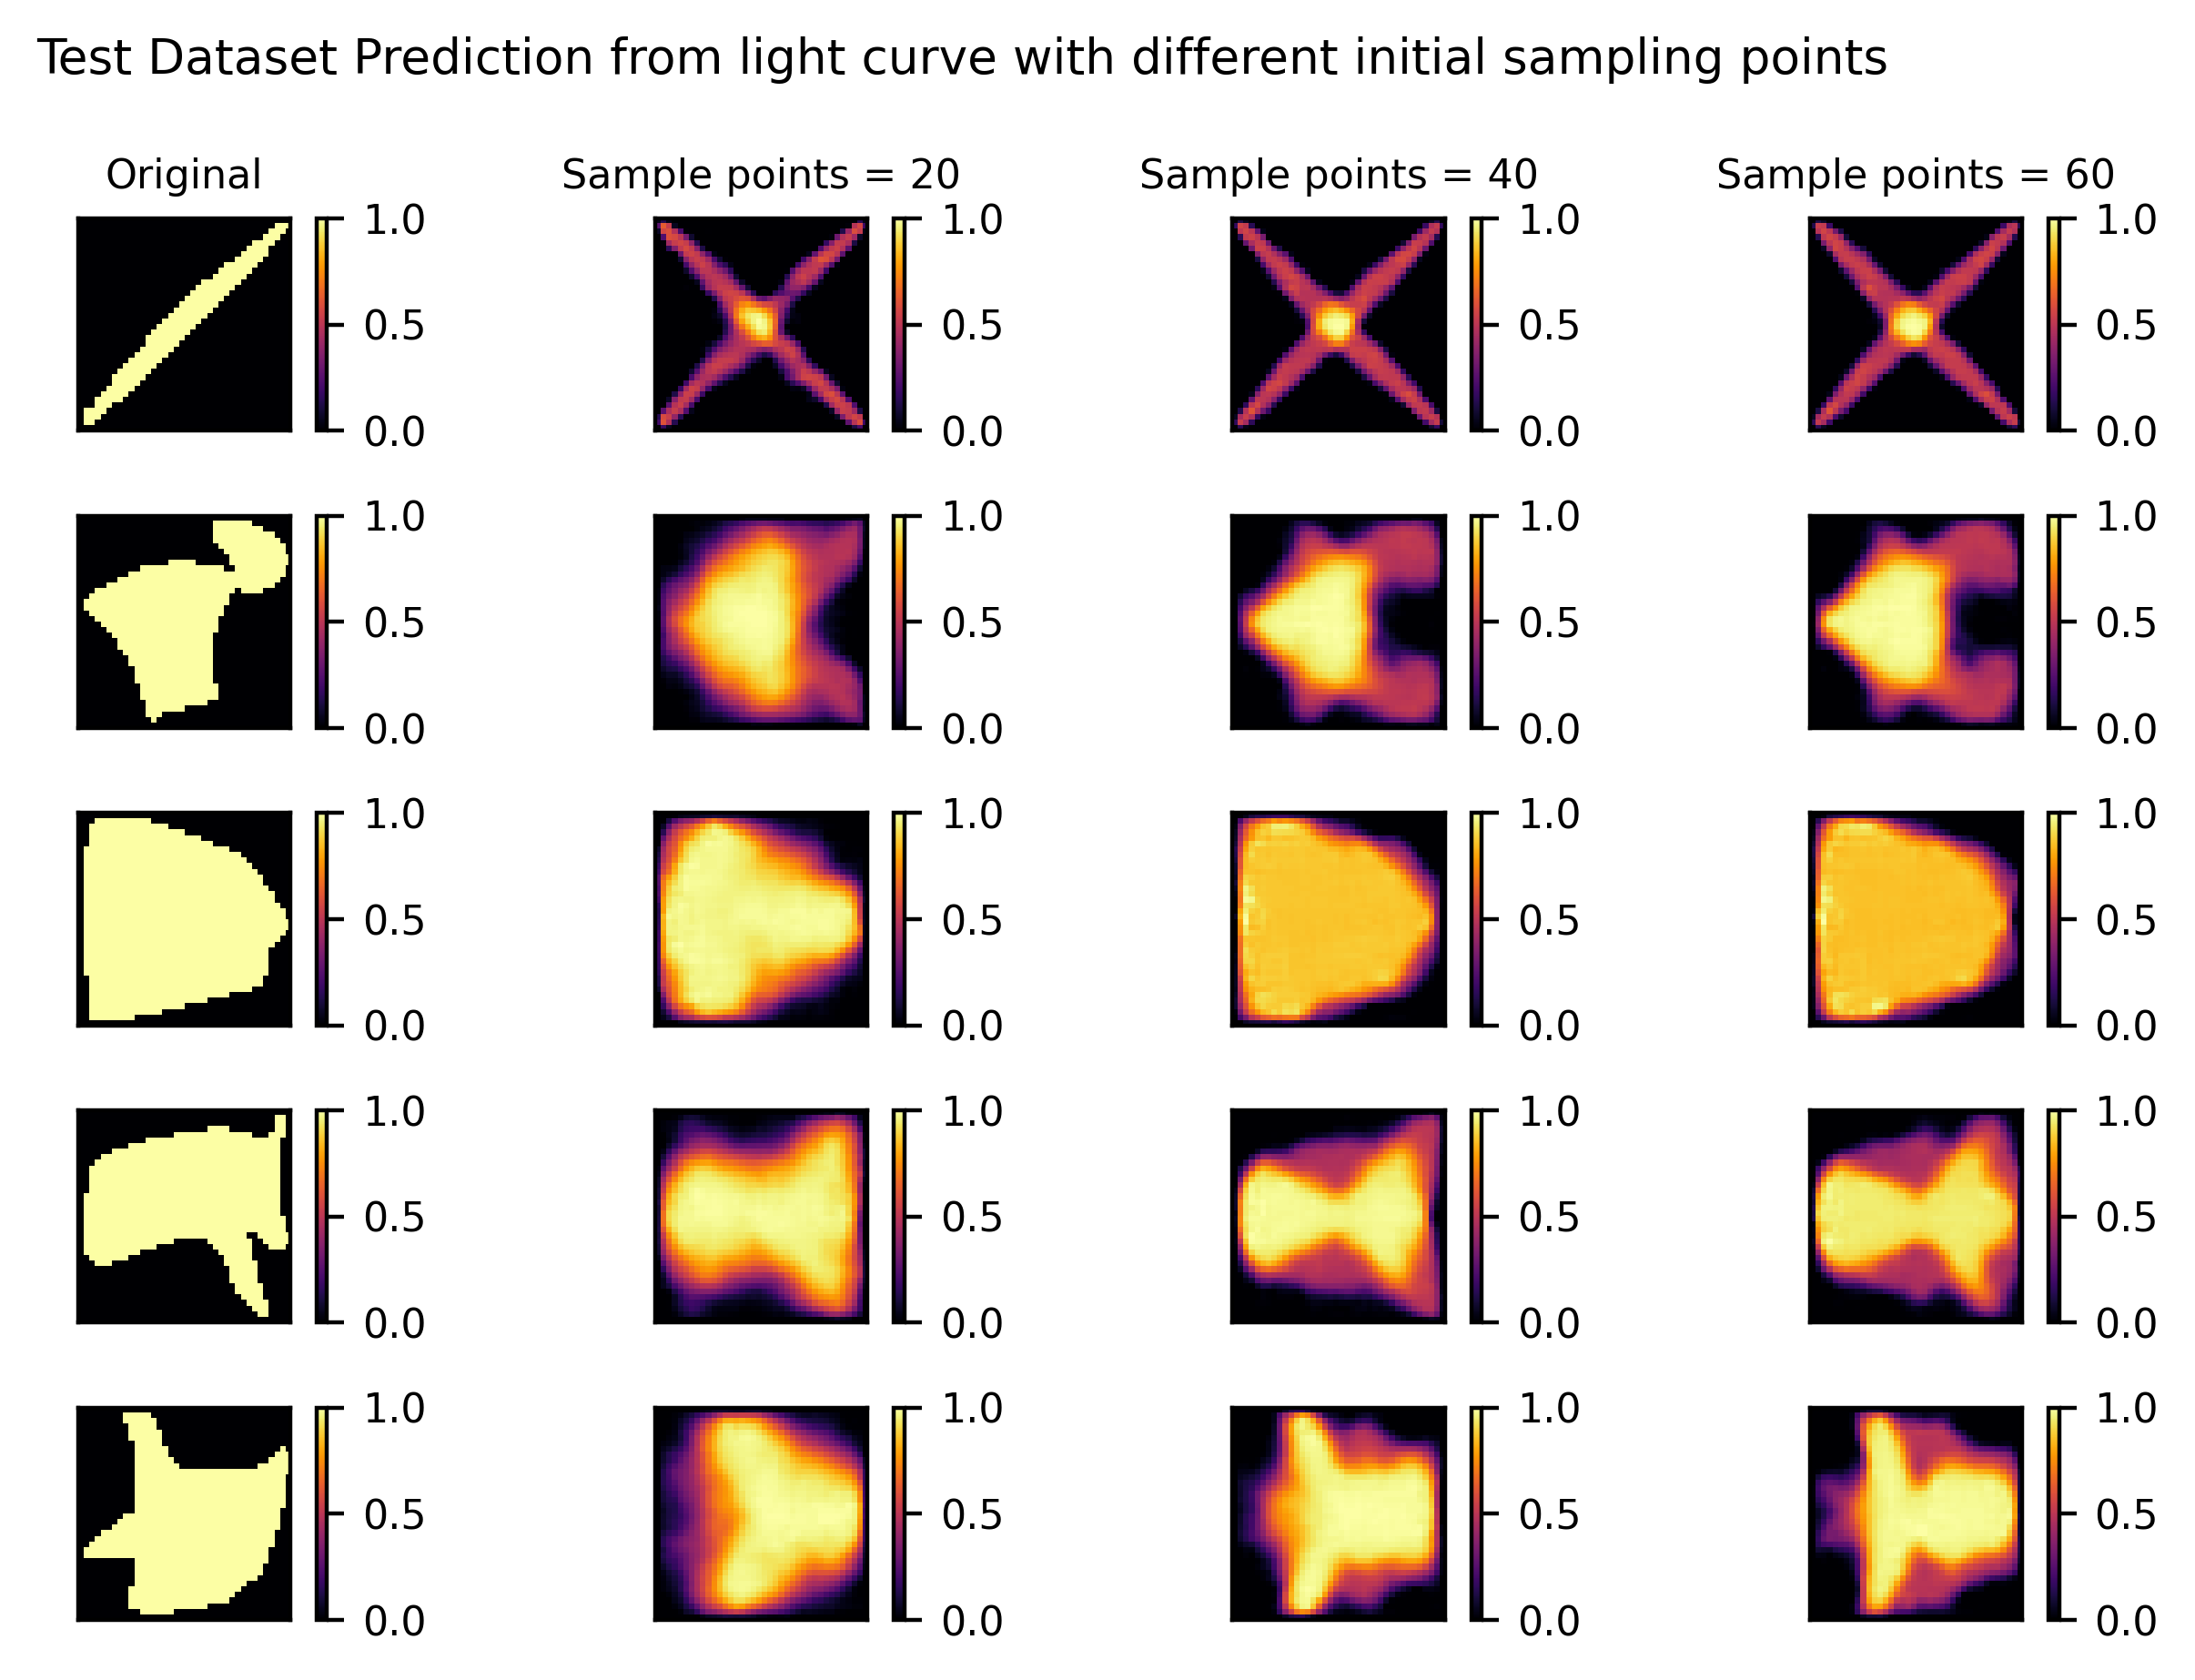

In [19]:
# Plot predicted shapes
num = 5
fig,ax=plt.subplots(num,4, figsize=(8,5), gridspec_kw={ 'width_ratios': [1,1,1,1],
        'wspace': 0.1,'hspace': 0.4})
plt.rcParams['figure.dpi'] = 400
plt.rcParams.update({'font.size': 8})

ax[0][0].set_title('Original',size=8)
ax[0][1].set_title('Sample points = 20',size=8)
ax[0][2].set_title('Sample points = 40',size=8)
ax[0][3].set_title('Sample points = 60',size=8)



temp = np.linspace(0, len(test_lc_scaled_append)-1,len(test_lc_scaled_append))
index_test_array = np.random.choice(temp, size=(num,), replace=False)

for i in range(num):
    k =  random.randint(0, len(test_lc_scaled_append)-1) # i i # int(index_test_array[i]) # 
    print("k = ",k)
    ax[i][0].tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
    ax[i][1].tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
    ax[i][2].tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
    ax[i][3].tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)


    img = ax[i][0].imshow(test_shape[k],cmap='inferno')
    plt.colorbar(img)  

    img = ax[i][1].imshow(test_predict_shape_20[k],cmap='inferno')
    plt.colorbar(img)   

    img = ax[i][2].imshow(test_predict_shape_40[k],cmap='inferno')
    plt.colorbar(img)   

    img = ax[i][3].imshow(test_predict_shape_60[k],cmap='inferno')
    plt.colorbar(img)     

plt.suptitle('Test Dataset Prediction from light curve with different initial sampling points')
plt.show()